## Gradient Descent Implementation

In this Python notebook we will go through an example of implementing **Gradient Descent** in simple and multiple linear regression, for this we will be using housing dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import os
import glob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from sklearn.feature_selection import RFE
from pathlib import Path

In [3]:
l_input_files=['Housing']
cur_dir=os.getcwd()
data_dir=os.path.join(cur_dir,'data','*')
ls_files=[f  for f in glob.glob(data_dir) \
          if (Path(f).stem in l_input_files and os.path.basename(f).endswith('csv')) ]

#print(ls_files)

housing=pd.DataFrame()
for f in ls_files:
    print('file to be read: {}'.format(os.path.basename(f)))
    housing=pd.read_csv(f)

file to be read: Housing.csv


In [4]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
# Converting Yes to 1 and No to 0
housing['mainroad'] = housing['mainroad'].map({'yes': 1, 'no': 0})
housing['guestroom'] = housing['guestroom'].map({'yes': 1, 'no': 0})
housing['basement'] = housing['basement'].map({'yes': 1, 'no': 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes': 1, 'no': 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes': 1, 'no': 0})
housing['prefarea'] = housing['prefarea'].map({'yes': 1, 'no': 0})

In [6]:
#Converting furnishingstatus column to binary column using get_dummies
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)
housing = pd.concat([housing,status],axis=1)
housing.drop(['furnishingstatus'],axis=1,inplace=True)

In [7]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [8]:
#Normalisisng the data
housing = (housing - housing.mean())/housing.std()
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,4.562174,1.045766,1.402131,1.420507,1.376952,0.405251,-0.464888,-0.733865,-0.219063,1.471267,1.516299,1.803284,-0.844113,-0.69579
1,4.000809,1.755397,1.402131,5.400847,2.529700,0.405251,-0.464888,-0.733865,-0.219063,1.471267,2.676950,-0.553526,-0.844113,-0.69579
2,4.000809,2.216196,0.047235,1.420507,0.224204,0.405251,-0.464888,1.360148,-0.219063,-0.678439,1.516299,1.803284,1.182502,-0.69579
3,3.982096,1.082630,1.402131,1.420507,0.224204,0.405251,-0.464888,1.360148,-0.219063,1.471267,2.676950,1.803284,-0.844113,-0.69579
4,3.551716,1.045766,1.402131,-0.569663,0.224204,0.405251,2.147110,1.360148,-0.219063,1.471267,1.516299,-0.553526,-0.844113,-0.69579


In [9]:
# Putting feature variable to X
X = housing['area']
# Putting response variable to y
y = housing['price']

In [10]:
# Conventional way to import seaborn
import seaborn as sns

# To visualise in the notebook
%matplotlib inline

C:\Per\py\Anaconda\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


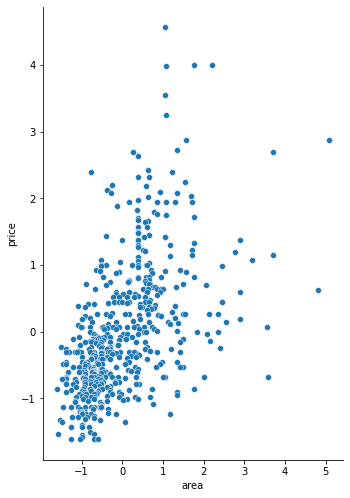

In [11]:
# Visualise the relationship between the features and the response using scatterplots
sns.pairplot(housing, x_vars='area', y_vars='price',size=7, aspect=0.7, kind='scatter')

**For linear regressions we use a cost function known as the mean squared error or MSE.**

<img src="gd1.png"/>

Now we will apply partial derivative with respect to m and c and will equate it to zero to find the least value of m and c for which our cost function get the lowest value as possible.

<img src="gd2.png"/>

Now to apply gradient descent from scratch we need our X and y variables as numpy arrays, Let's convert them.

In [12]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [13]:
# Applying gradient descent by creating UDF.
def gradient(X, y, m_current=0, c_current=0, iters=1000, learning_rate=0.001):
    N = float(len(y))
    gd_df = pd.DataFrame( columns = ['m_current', 'c_current','cost'])
    for i in range(iters):
        y_current = (m_current * X) + c_current
        cost = sum([data**2 for data in (y-y_current)]) / N
        m_gradient = -(2/N) * sum(X * (y - y_current))
        c_gradient = -(2/N) * sum(y - y_current)
        m_current = m_current - (learning_rate * m_gradient)
        c_current = c_current - (learning_rate * c_gradient)
        gd_df.loc[i] = [m_current,c_current,cost]
    return(gd_df)


In [14]:
gradient(X,y)

,m_current,c_current,cost
0,0.001070,5.117211e-19,0.998165
1,0.002138,1.080481e-18,0.997021
2,0.003204,2.258744e-18,0.995882
3,0.004267,3.415820e-18,0.994747
4,0.005329,3.474489e-18,0.993617
...,...,...,...
995,0.462753,2.171596e-16,0.716775
996,0.462900,2.170977e-16,0.716754
997,0.463045,2.173560e-16,0.716733
998,0.463191,2.167595e-16,0.716711


<AxesSubplot:xlabel='index'>

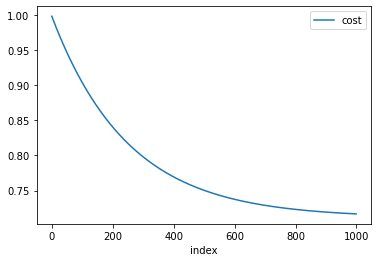

In [15]:
gradient(X,y).reset_index().plot.line(x='index', y=['cost'])

### Applying Gradient Descent for multiple variable

In [16]:
# Putting feature variable to X
X = housing[['area','bedrooms']]
# Putting response variable to y
y = housing['price']

In [17]:
## Add a columns of 1s as intercept to X.
X['intercept'] = 1
#X = X.reindex_axis(['intercept','area','bedrooms'], axis=1)

C:\Users\RPAREPAL\AppData\Local\Temp/ipykernel_10736/3697886518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


In [18]:
X.head()

,area,bedrooms,intercept
0,1.045766,1.402131,1
1,1.755397,1.402131,1
2,2.216196,0.047235,1
3,1.082630,1.402131,1
4,1.045766,1.402131,1


In [19]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [20]:
# Theta needed to be changed with the number of response varaible used.
theta = np.matrix(np.array([0,0,0])) 
alpha = 0.01
iterations = 1000

In [21]:
import numpy as np

def compute_cost(X, y, theta):
    return np.sum(np.square(np.matmul(X, theta) - y)) / (2 * len(y))

More on [Numpy Matmul](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html)

<img src="gd.png"/>

In [22]:
def gradient_descent_multi(X, y, theta, alpha, iterations):
    theta = np.zeros(X.shape[1])
    m = len(X)
    gdm_df = pd.DataFrame( columns = ['Bets','cost'])

    for i in range(iterations):
        gradient = (1/m) * np.matmul(X.T, np.matmul(X, theta) - y)
        theta = theta - alpha * gradient
        cost = compute_cost(X, y, theta)
        gdm_df.loc[i] = [theta,cost]

    return gdm_df

In [23]:
gradient_descent_multi(X, y, theta, alpha, iterations)

,Bets,cost
0,"[0.005350138644096792, 0.0036582155967153037, ...",0.494906
1,"[0.01064132895186077, 0.007271806428759801, 3....",0.490824
2,"[0.015874226967184043, 0.0108413072787747, 5.3...",0.486834
3,"[0.021049481374934603, 0.014367246596957, 7.28...",0.482935
4,"[0.026167733584010235, 0.01785014657542254, 9....",0.479124
...,...,...
995,"[0.4916558741575689, 0.2918452258722242, 3.336...",0.314176
996,"[0.49165609672441263, 0.2918450929508475, 3.33...",0.314176
997,"[0.4916563172711537, 0.29184496101887913, 3.33...",0.314176
998,"[0.4916565358164564, 0.2918448300695053, 3.334...",0.314176


<AxesSubplot:xlabel='index'>

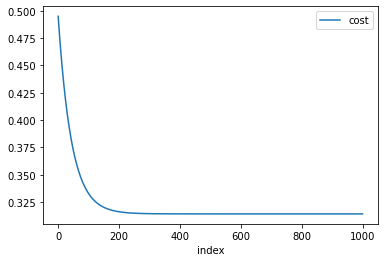

In [24]:
gradient_descent_multi(X, y, theta, alpha, iterations).reset_index().plot.line(x='index', y=['cost'])